In [1]:
from numba import jit
import numpy as np
import scipy.constants as constants
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [2]:
def initializeGrid(length_dimension, time_dimension, dimensions, dl, dt):
    
    E_fields = np.zeros((dimensions, length_dimension, time_dimension))
    H_fields = np.zeros((dimensions, length_dimension, time_dimension))
    
    E_coefficients = np.zeros(9)
    H_coefficients = np.zeros(9)
    impedance = constants.c*constants.mu_0
   
    E_coefficients[0] = 1.0
    E_coefficients[3] = 1.0 
    E_coefficients[6] = 1.0
    
    E_coefficients[1] = dt/(constants.epsilon_0*dl[1])
    E_coefficients[2] = dt/(constants.epsilon_0*dl[2])
    
    E_coefficients[4] = dt/(constants.epsilon_0*dl[2])
    E_coefficients[5] = dt/(constants.epsilon_0*dl[0])
    
    E_coefficients[7] = dt/(constants.epsilon_0*dl[0])
    E_coefficients[8] = dt/(constants.epsilon_0*dl[1])
    
    
    H_coefficients[0] = 1.0
    H_coefficients[3] = 1.0
    H_coefficients[6] = 1.0
    
    H_coefficients[1] = dt/(constants.mu_0*dl[2])
    H_coefficients[2] = dt/(constants.mu_0*dl[1])
    
    H_coefficients[4] = dt/(constants.mu_0*dl[0])
    H_coefficients[5] = dt/(constants.mu_0*dl[2])
    
    
    H_coefficients[7] = dt/(constants.mu_0*dl[1])
    H_coefficients[8] = dt/(constants.mu_0*dl[0])
    
    
    return E_fields, H_fields, E_coefficients, H_coefficients

In [3]:
def updateMagneticFields(n, H_coefficients, H_fields, E_fields, time, m, dimensions):
    for i in range(dimensions):
        for j in range(n-m[-1]):
            H_fields[i, j, time+1] = H_coefficients[2*i]*H_fields[i, j, time] + H_coefficients[2*i+1]*(
                (E_fields[(i+1)%dimensions, j+m[(i+2)%dimensions], time]-E_fields[(i+1)%dimensions, j, time]
                )-(E_fields[(i+2)%dimensions, j+m[(i+1)%dimensions], time]-E_fields[(i+2)%dimensions, j, time]))
    return H_fields

def updateElectricFields(n, E_coefficients, H_fields, E_fields, time, m, dimensions):
    for i in range (dimensions):
        for j in range(m[-1], n):
            E_fields[i, j, time] = E_coefficients[2*i]*E_fields[i, j, time-1] + E_coefficients[2*i+1]*(
                (H_fields[(i+2)%dimensions, j, time]-H_fields[(i+2)%dimensions, j-m[(i+1)%dimensions], time]
                )-(H_fields[(i+1)%dimensions, j, time]-H_fields[(i+1)%dimensions, j-m[(i+2)%dimensions], time]))
    return E_fields

In [4]:
def getSource(time, ppw):
    #getSource(time, position, cdtds, ppw, components):
        
    sourceMagnitude = 0
    
    if time >= 0: 
        arg = np.pi*((time) / ppw - 1.0)
        #arg = np.pi*((cdtds*time-position) / ppw - 1.0)
        arg = arg * arg
        sourceMagnitude = (1.0-2.0*arg)*np.exp(-arg)
        
        
    tw=200e-12
    to=4*tw
    pulse = 0

    if time >= 0:
        pulse=-2.0*(((time)-to)/tw)*np.exp(-(((time)-to)/tw)**2);
        pulse=np.exp(-(((time)-to)/tw)**2);
   
    
    #return np.outer(components, sourceMagnitude)
   
    return sourceMagnitude
 
    
    #return pulse
    
def getProjections(m, psi):
    # calculate all projections
    if m[0] == 0:
        phi = np.pi/2
    else:
        phi = np.arctan(m[1]/m[0])
    
    if m[2] == 0:
        theta = np.pi/2
    else:
        theta = np.arctan(np.sqrt(m[0]**2+m[1]**2)/m[2])
    
    return np.array([np.cos(psi)*np.sin(phi)-np.sin(psi)*np.cos(theta)*np.cos(phi),
                    -np.cos(psi)*np.cos(phi)-np.sin(psi)*np.cos(theta)*np.sin(phi),
                     np.sin(psi)*np.sin(theta)]), np.array([np.sin(psi)*np.sin(phi)+np.cos(psi)*np.cos(theta)*np.cos(phi),
                    -np.sin(psi)*np.cos(phi)+np.cos(psi)*np.cos(theta)*np.sin(phi),
                    -np.cos(psi)*np.sin(theta)]), np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])


In [6]:
def takeSnapshot(fields, number, component):
    np.save('./electric_z_{}.npy'.format(number), fields[component, :, :, :])

In [5]:
# Basic Model parameters
dimensions = 3


# Main 3D grid parameters
number_x = 25
number_y = 25
number_z = 25
# TF/SF box coordinates 
corners=np.array([5, 5, 5, 20, 20, 20])

# Main Grid Numerber of Iterations
time_duration = 200
snapshot = 10

# Spatial and temporal steps and key parameters for both grids
dx = 0.001
dy = 0.001
dz = 0.001
epsilon_r = 1.0
mu_r = 1.0
dt = 1.0 / (constants.c * np.sqrt((1.0/dx**2)+(1.0/dy**2)+(1.0/dz**2)))
Zo = np.sqrt(constants.mu_0/constants.epsilon_0)

# Source informaytion
ppw = 20*dt


# DPW information 
#a buffer for avoind boundary effects
number = 50

iterations = time_duration
# Propagation direction
m_x = 1
m_y = 2
m_z = 3
# Plane wave E field polarization angle with the direction of propagation 
psi = np.pi/2


m = np.array([m_x, m_y, m_z, 0])
m[-1] = np.amax(m)
length = 2*np.sum(m[:-1])*number
Rstart = m[-1]
Rstop = length - m[-1];

# Projections for field components
projections_e, projections_h, P = getProjections(m, psi)
projections_h = projections_h / Zo

# Calculating dr that is needed for sourcing the 1D array
if m_x == 0:
    if m_y == 0:
        if m_z == 0:
            raise ValueError("not all M values can be zero")
        else:
            dr = P[2]*dz/m_z
    else:
        dr = P[1]*dy/m_y
else:
    dr = P[0]*dx/m_x

d = np.array([dx, dy, dz, dr])


In [6]:
# Calculate and store the 1D fields 

start = time.time()

E, H, C, D = initializeGrid(length, iterations, dimensions, d, dt)

real_time = 0
for t in range(1,iterations-1):
    
    for r in range(m[-1]):
        H[0, r, t] = projections_h[0]*getSource(real_time - (r+(m[1]+m[2])*0.5)*d[-1]/constants.c, ppw)
        H[1, r, t] = projections_h[1]*getSource(real_time - (r+(m[0]+m[2])*0.5)*d[-1]/constants.c, ppw)
        H[2, r, t] = projections_h[2]*getSource(real_time - (r+(m[0]+m[1])*0.5)*d[-1]/constants.c, ppw)
        
    H[0,Rstart:Rstop,t] = H[0,Rstart:Rstop,t-1] + D[1]*(E[1,Rstart+m[2]:Rstop+m[2],t-1]-E[1,Rstart:Rstop,t-1]) \
    - D[2]*(E[2,Rstart+m[1]:Rstop+m[1],t-1]-E[2,Rstart:Rstop,t-1])
    
    H[1,Rstart:Rstop,t] = H[1,Rstart:Rstop,t-1] + D[4]*(E[2,Rstart+m[0]:Rstop+m[0],t-1]-E[2,Rstart:Rstop,t-1]) \
    - D[5]*(E[0,Rstart+m[2]:Rstop+m[2],t-1]-E[0,Rstart:Rstop,t-1])
    
    H[2,Rstart:Rstop,t] = H[2,Rstart:Rstop,t-1] + D[7]*(E[0,Rstart+m[1]:Rstop+m[1],t-1]-E[0,Rstart:Rstop,t-1]) \
    - D[8]*(E[1,Rstart+m[0]:Rstop+m[0],t-1]-E[1,Rstart:Rstop,t-1])
    
    real_time = real_time + 0.5*dt
       
    
    for r in range(m[-1]):
        E[0, r, t] = projections_e[0]*getSource(real_time - (r+m[0]*0.5)*d[-1]/constants.c, ppw)
        E[1, r, t] = projections_e[1]*getSource(real_time - (r+m[1]*0.5)*d[-1]/constants.c, ppw)
        E[2, r, t] = projections_e[2]*getSource(real_time - (r+m[2]*0.5)*d[-1]/constants.c, ppw)
   
    
    E[0,Rstart:Rstop,t] = E[0,Rstart:Rstop,t-1] + C[1]*(H[2,Rstart:Rstop,t]-H[2,Rstart-m[1]:Rstop-m[1],t]) \
    - C[2]*(H[1,Rstart:Rstop,t]-H[1,Rstart-m[2]:Rstop-m[2],t])

    E[1,Rstart:Rstop,t] = E[1,Rstart:Rstop,t-1] + C[4]*(H[0,Rstart:Rstop,t]-H[0,Rstart-m[2]:Rstop-m[2],t]) \
    - C[5]*(H[2,Rstart:Rstop,t]-H[2,Rstart-m[0]:Rstop-m[0],t])
    
    E[2,Rstart:Rstop,t] = E[2,Rstart:Rstop,t-1] + C[7]*(H[1,Rstart:Rstop,t]-H[1,Rstart-m[0]:Rstop-m[0],t]) \
    - C[8]*(H[0,Rstart:Rstop,t]-H[0,Rstart-m[1]:Rstop-m[1],t])

    real_time = real_time + 0.5*dt
    
    
    #H = updateMagneticFields(length, D, H, E, i, m, dimensions)
    
    
    
    #E = updateElectricFields(length, C, H, E, i+1, m, dimensions) 
    
    #if (i % snapshot == 0):
        #fields_3d = get3DFields(fields_3d, E, H, i, dimensions, corners)
        #takeSnapshot(fields_3d, i, -1)
    
    
end = time.time()
print("Elapsed (with compilation) = %s sec" % (end - start))

Elapsed (with compilation) = 0.052018165588378906 sec


In [9]:
np.savetxt('./electric_z.csv', E[-1, :, :])

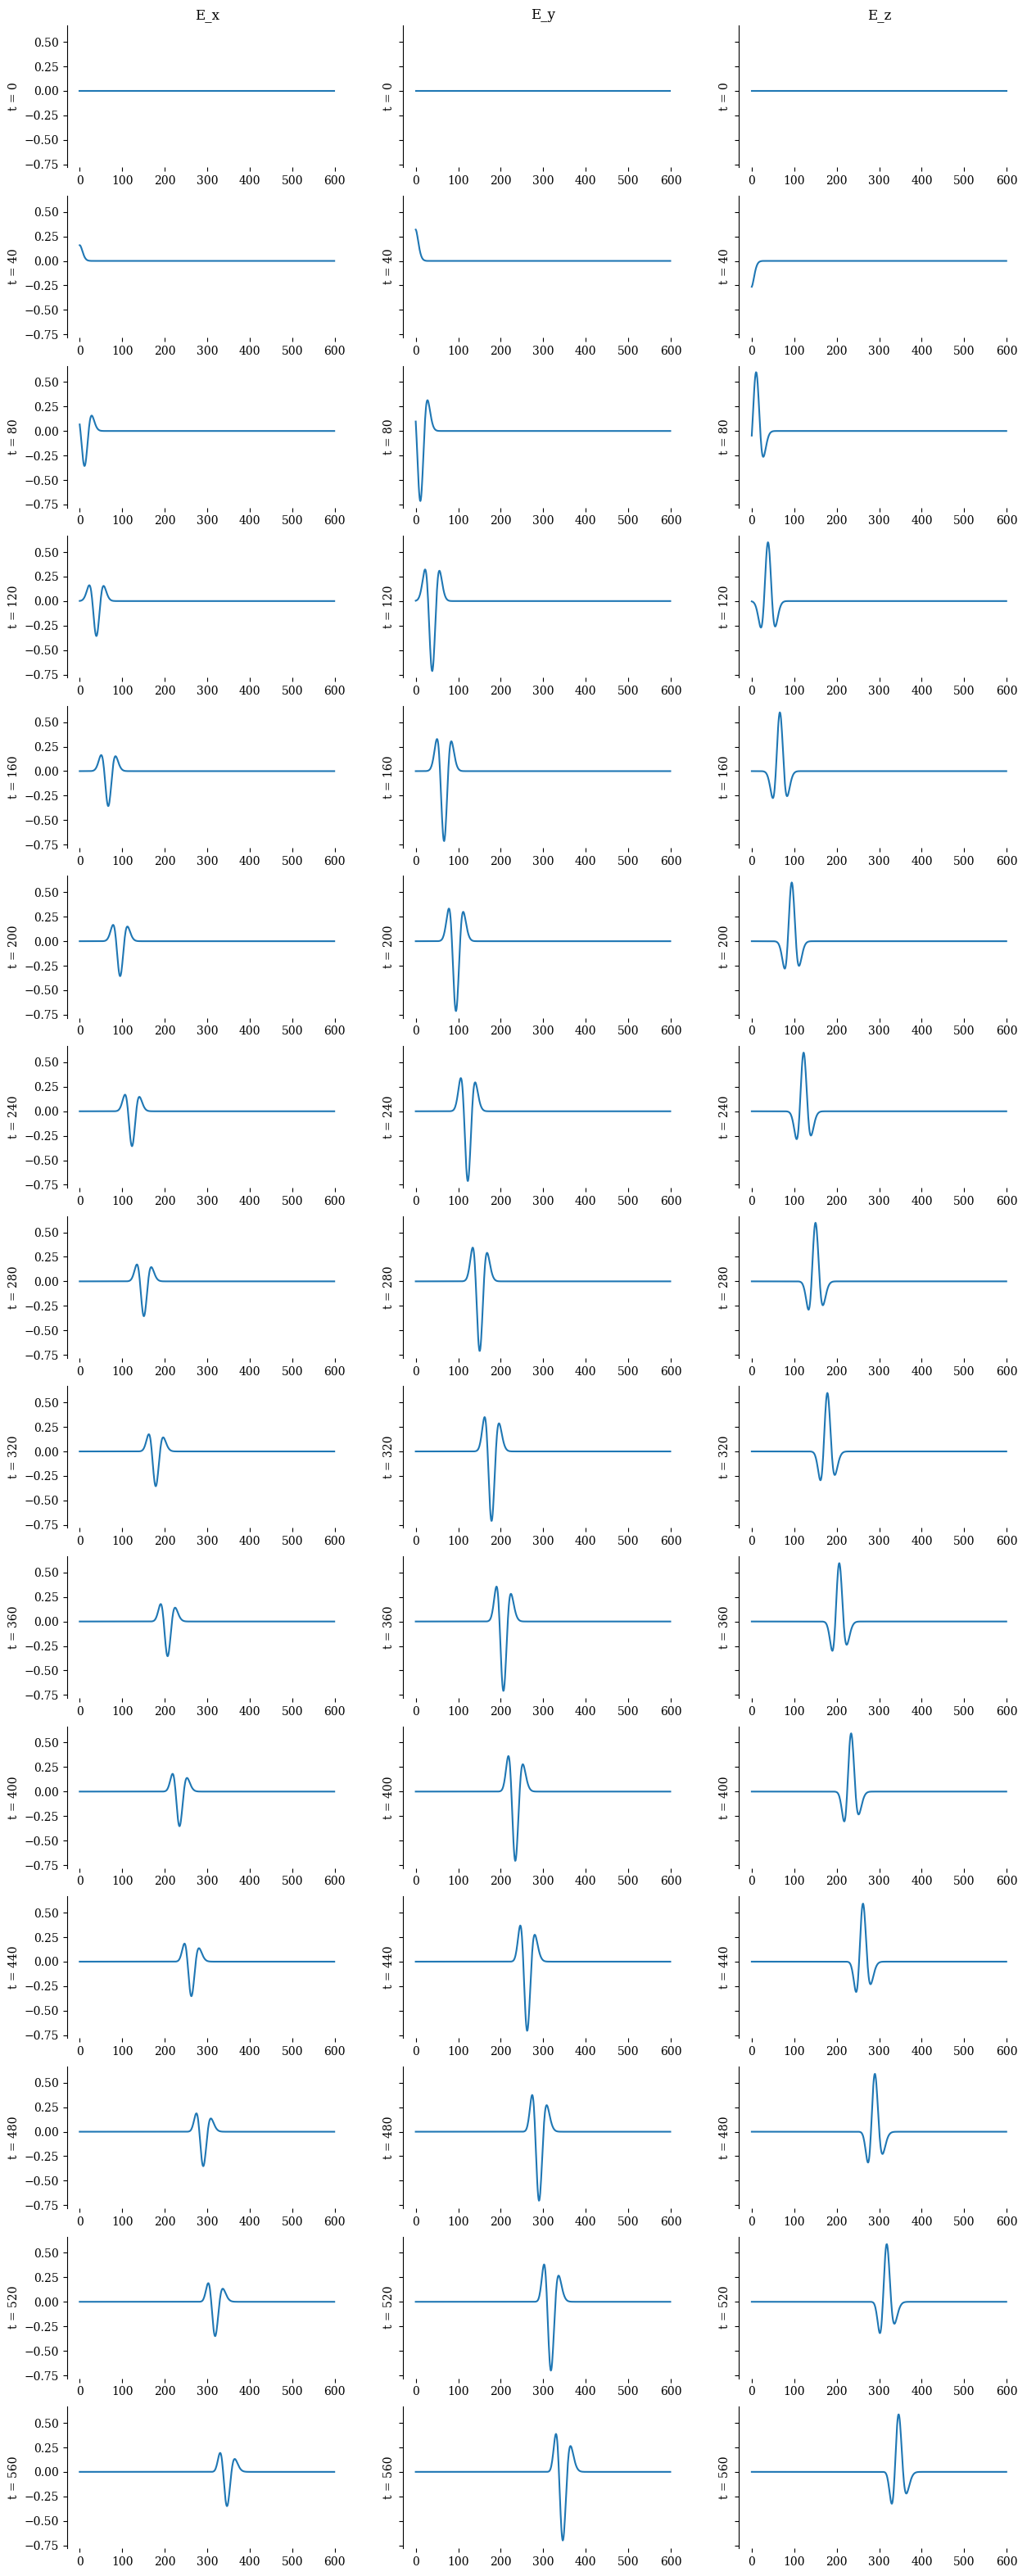

In [7]:
N_plots = 15
Time_step = round(iterations/N_plots)
fig, axes = plt.subplots(N_plots, 3, figsize=(15, 40), sharey=True)


for i in range(N_plots):
    axes[i, 0].plot(E[0, :, i*Time_step])
    axes[i, 0].set_ylabel('t = {}'.format(i*40), rotation='vertical')
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].spines['right'].set_visible(False)
    axes[i, 0].spines['bottom'].set_visible(False)
axes[0, 0].set_title("E_x")

for i in range(N_plots):
    axes[i, 1].plot(E[1, :, i*Time_step])
    axes[i, 1].set_ylabel('t = {}'.format(i*40), rotation='vertical')
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['bottom'].set_visible(False)
axes[0, 1].set_title("E_y")

for i in range(N_plots):
    axes[i, 2].plot(E[2, :, i*Time_step])
    axes[i, 2].set_ylabel('t = {}'.format(i*40), rotation='vertical')
    axes[i, 2].spines['top'].set_visible(False)
    axes[i, 2].spines['right'].set_visible(False)
    axes[i, 2].spines['bottom'].set_visible(False)
axes[0, 2].set_title("E_z")

plt.savefig("./electric.png")
plt.show()

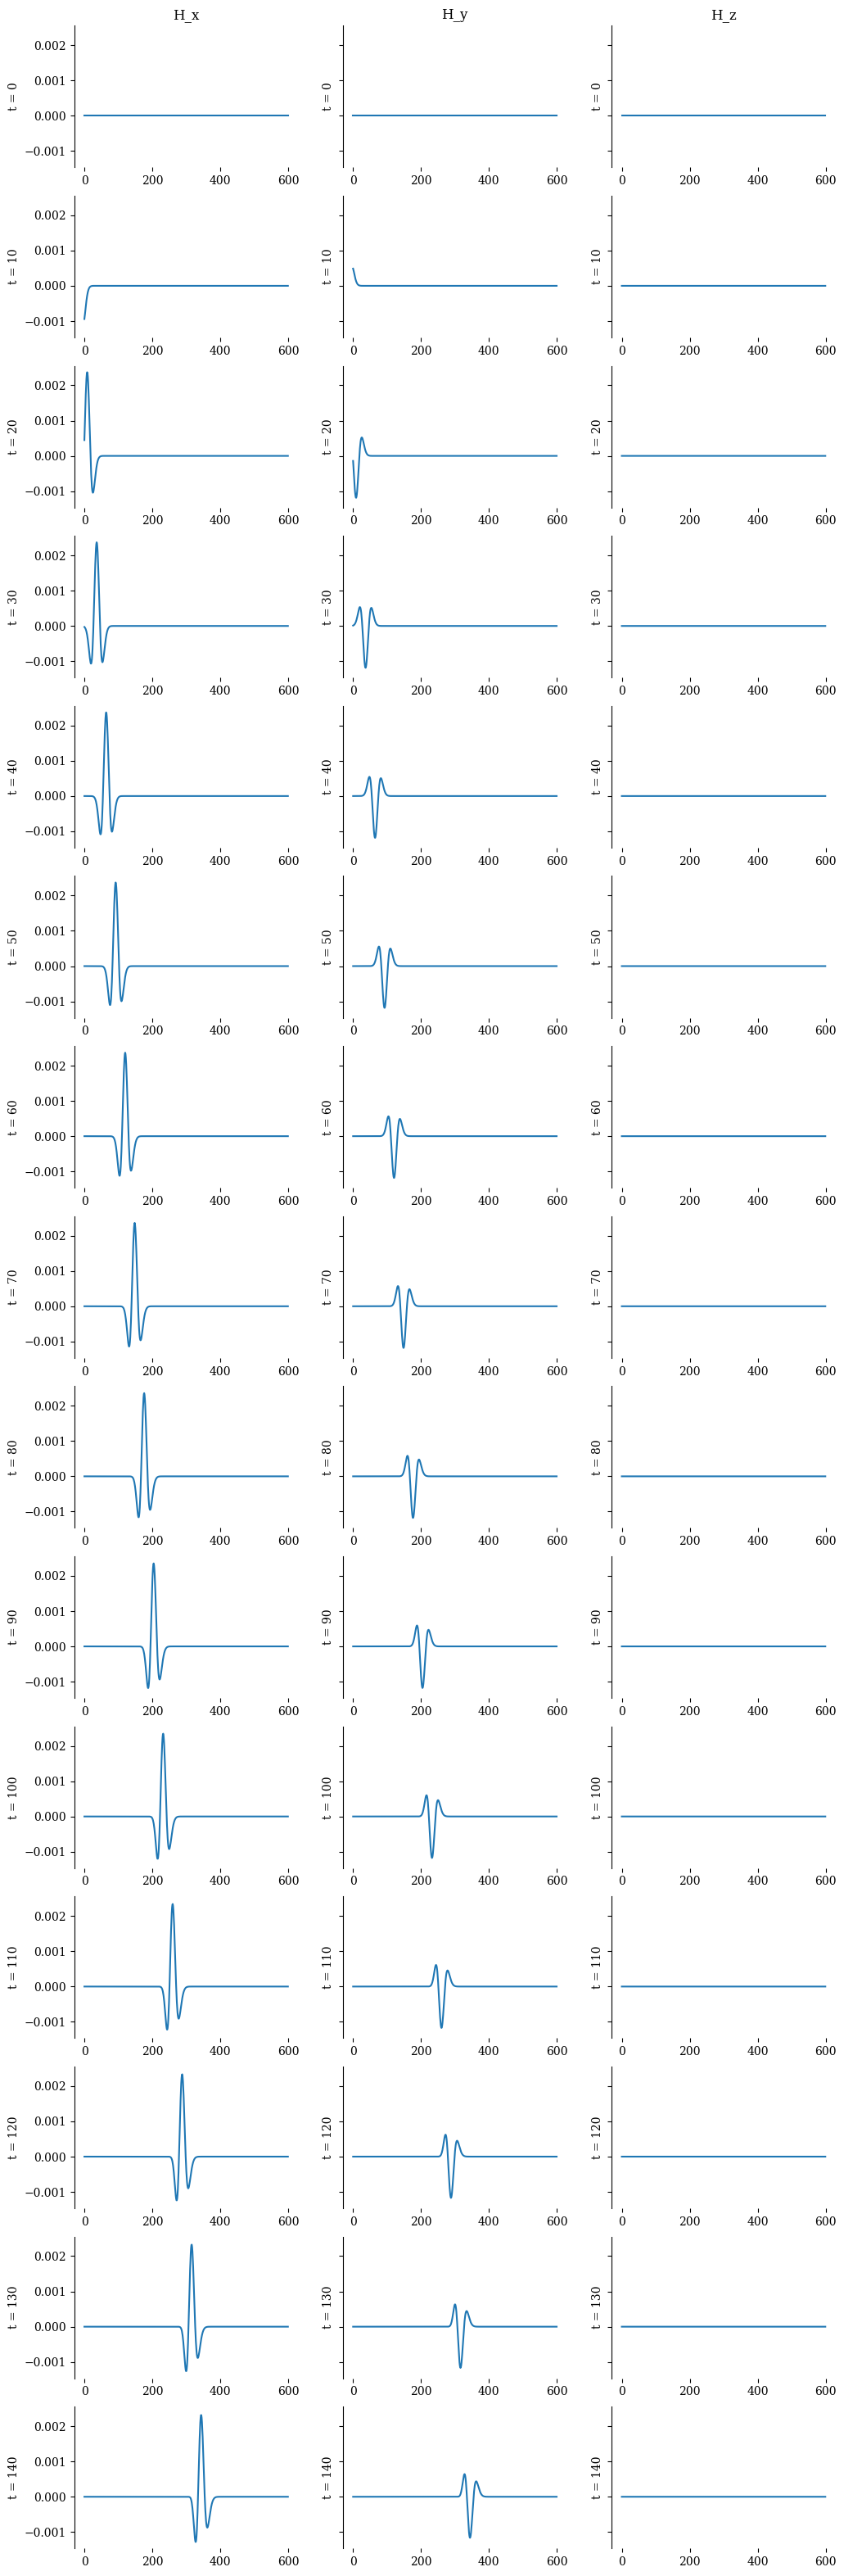

In [8]:
N_plots = 15
Time_step = round(iterations/N_plots)
fig, axes = plt.subplots(N_plots, 3, figsize=(12, 40), sharey=True)

for i in range(N_plots):
    axes[i, 0].plot(H[0, :, i*Time_step])
    axes[i, 0].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].spines['right'].set_visible(False)
    axes[i, 0].spines['bottom'].set_visible(False)
axes[0, 0].set_title("H_x")

for i in range(N_plots):
    axes[i, 1].plot(H[1, :, i*Time_step])
    axes[i, 1].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['bottom'].set_visible(False)
axes[0, 1].set_title("H_y")

for i in range(N_plots):
    axes[i, 2].plot(H[2, :, i*Time_step])
    axes[i, 2].set_ylabel('t = {}'.format(i*10), rotation='vertical')
    axes[i, 2].spines['top'].set_visible(False)
    axes[i, 2].spines['right'].set_visible(False)
    axes[i, 2].spines['bottom'].set_visible(False)
axes[0, 2].set_title("H_z")

plt.savefig("./magnetic.png")
plt.show()

In [12]:
fields = np.genfromtxt('./electric_z.csv')
print(fields.shape)

E_z = np.zeros((number+corners[0], number+corners[1], number+corners[2]))

(300, 200)


In [13]:
t = 120

for i in range(number):
    for j in range(number):
        for k in range(number):
            E_z[i+corners[0], j+corners[1], k+corners[2]] = fields[np.dot(m[:-1], np.array([i, j, k])), t]

(300, 200)


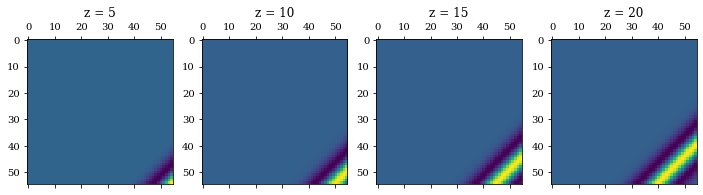

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(12, 8))

print(fields.shape)

for i in range(4):
    axes[i].matshow(E_z[:, :, (i+1)*5])
    axes[i].set_title('z = {}'.format((i+1)*5))

plt.show()

In [15]:
def initialize3DGrid(n_x, n_y, n_z, dl, dt):
    #impedance = constants.c*constants.mu_0
    #size_x = n_x
    #size_y = n_y
    #cdtds = 1/np.sqrt(3.0)
    
    # Intitialise 3D grid. The Grid contains Nx, Ny, Nz cells and has +1 component where is needed.
    
    e_x = np.zeros((n_x, n_y+1, n_z+1))
    e_y = np.zeros((n_x+1, n_y, n_z+1))
    e_z = np.zeros((n_x+1, n_y+1, n_z))
    h_x = np.zeros((n_x+1, n_y, n_z))
    h_y = np.zeros((n_x, n_y+1, n_z))
    h_z = np.zeros((n_x, n_y, n_z+1))
    
    E_co = np.zeros(9)
    H_co = np.zeros(9)
    
    
    E_co[0] = 1.0
    E_co[3] = 1.0 
    E_co[6] = 1.0
    
    E_co[1] = dt/(constants.epsilon_0*dl[1])
    E_co[2] = dt/(constants.epsilon_0*dl[2])
    
    E_co[4] = dt/(constants.epsilon_0*dl[2])
    E_co[5] = dt/(constants.epsilon_0*dl[0])
    
    E_co[7] = dt/(constants.epsilon_0*dl[0])
    E_co[8] = dt/(constants.epsilon_0*dl[1])
    
    
    H_co[0] = 1.0
    H_co[3] = 1.0
    H_co[6] = 1.0
    
    H_co[1] = dt/(constants.mu_0*dl[2])
    H_co[2] = dt/(constants.mu_0*dl[1])
    
    H_co[4] = dt/(constants.mu_0*dl[0])
    H_co[5] = dt/(constants.mu_0*dl[2])
    
    
    H_co[7] = dt/(constants.mu_0*dl[1])
    H_co[8] = dt/(constants.mu_0*dl[0])
    
    
    #cee = 1.0
    #ceh = cdtds * impedance
    #chh = 1.0
    #che = cdtds / impedance
    #np.array([cee, ceh, chh, che, cdtds])
    
    return e_x, e_y, e_z, h_x, h_y, h_z, E_co, H_co

In [16]:
#@jit(nopython=True)
def updateHFields(n_x, n_y, n_z, coefficients, h_x, h_y, h_z, e_x, e_y, e_z):
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                h_x[i, j, k] = coefficients[0]*h_x[i, j, k] + coefficients[1]*(e_y[i, j, k+1]-e_y[i, j, k])\
                -coefficients[2]*(e_z[i, j+1, k]-e_z[i, j, k])
                
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                h_y[i, j, k] = coefficients[3]*h_y[i, j, k] + coefficients[4]*(e_z[i+1, j, k]-e_z[i, j, k])\
                -coefficients[5]*(e_x[i, j, k+1]-e_x[i, j, k])
                
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                h_z[i, j, k] = coefficients[6]*h_z[i, j, k] + coefficients[7]*(e_x[i, j+1, k]-e_x[i, j, k])\
                -coefficients[8]*(e_y[i+1, j, k]-e_y[i, j, k])
                
    return h_x, h_y, h_z

#@jit(nopython=True)
def updateEFields(n_x, n_y, n_z, coefficients, h_x, h_y, h_z, e_x, e_y, e_z):
    for i in range(n_x):
        for j in range(1, n_y):
            for k in range(1, n_z):
                e_x[i, j, k] = coefficients[0]*e_x[i, j, k] + coefficients[1]*(h_z[i, j, k]-h_z[i, j-1, k])\
                -coefficients[2]*(h_y[i, j, k]-h_y[i, j, k-1])
                
    for i in range(1, n_x):
        for j in range(n_y):
            for k in range(1, n_z):
                e_y[i, j, k] = coefficients[3]*e_y[i, j, k] + coefficients[4]*(h_x[i, j, k]-h_x[i, j, k-1])\
                -coefficients[5]*(h_z[i, j, k]-h_z[i-1, j, k])
                
    for i in range(1, n_x):
        for j in range(1, n_y):
            for k in range(n_z):
                e_z[i, j, k] = coefficients[6]*e_z[i, j, k] + coefficients[7]*(h_y[i, j, k]-h_y[i-1, j, k])\
                -coefficients[8]*(h_x[i, j, k]-h_x[i, j-1, k])
                
    return e_x, e_y, e_z

In [17]:
#@jit(nopython=True)
def implementABC(n_x, n_y, n_z, 
                exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abdcoef,
                e_x, e_y, e_z, h_x, h_y, h_z):
    #implement ABC at x0
    i=0
    for j in range(n_y-1):
        for k in range(n_z):
            e_y[i, j, k] = eyx0[j, k] + abccoef*(e_y[i+1, j, k]-e_y[i, j, k])
            eyx0[j, k] = e_y[i+1, j, k]
    for j in range(n_y):
        for k in range(n_z-1):
            e_z[i, j, k] = ezx0[j, k] + abccoef*(e_z[i+1, j, k]-e_z[i, j, k])
            ezx0[j, k] = e_z[i+1, j ,k]
    
    #implement ABC at x1
    i=n_x-1
    for j in range(n_y-1):
        for k in range(n_z):
            e_y[i, j, k] = eyx1[j, k] + abccoef*(e_y[i-1, j, k]-e_y[i, j, k])
            eyx1[j, k] = e_y[i-1, j, k]
    for j in range(n_y):
        for k in range(n_z-1):
            e_z[i, j, k] = ezx1[j, k] + abccoef*(e_z[i-1, j, k]-e_z[i, j, k])
            ezx1[j, k] = e_z[i-1, j, k]
    
    #implement ABC at y0
    j=0
    for i in range(n_x-1):
        for k in range(n_z):
            e_x[i, j, k] = exy0[i, k] + abccoef*(e_x[i, j+1, k]-e_x[i, j, k])
            exy0[i, k] = e_x[i, j+1, k]
    for i in range(n_x):
        for k in range(n_z-1):
            e_z[i, j, k] = ezy0[i, k] + abccoef*(e_z[i, j+1, k]-e_z[i, j, k])
            ezy0[i, k] = e_z[i, j+1, k]
    #implement ABC at y1
    j=n_y-1
    for i in range(n_x-1):
        for k in range(n_z):
            e_x[i, j, k] = exy1[i, k] + abccoef*(e_x[i, j-1, k]-e_x[i, j, k])
            exy1[i, k] = e_x[i, j-1, k]
    for i in range(n_x):
        for k in range(n_z-1):
            e_z[i, j, k] = ezy1[i, k] + abccoef*(e_z[i, j-1, k]-e_z[i, j, k])
            ezy1[i, k] = e_z[i, j-1, k]
  
    #implement ABC at z0
    k=0
    for i in range(n_x-1):
        for j in range(n_y):
            e_x[i, j, k] = exz0[i, j] + abccoef*(e_x[i, j, k+1]-e_x[i, j, k])
            exz0[i, j] = e_x[i, j, k+1]
    for i in range(n_x):
        for j in range(n_y-1):
            e_y[i, j, k] = eyz0[i, j] + abccoef*(e_y[i, j, k+1]-e_y[i, j, k])
            eyz0[i, j] = e_z[i, j, k+1]
    #implement ABC at z1
    k=n_z-1
    for i in range(n_x-1):
        for j in range(n_y):
            e_x[i, j, k] = exz1[i, j] + abccoef*(e_x[i, j, k-1]-e_x[i, j, k])
            exz1[i, j] = e_x[i, j, k-1]
    for i in range(n_x):
        for j in range(n_y-1):
            e_y[i, j, k] = eyz1[i, j] + abccoef*(e_y[i, j, k-1]-e_y[i, j, k])
            eyz1[i, j] = e_z[i, j, k-1]
    
    return exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, e_x, e_y, e_z, h_x, h_y, h_z

In [18]:
def initializeABC(n_x, n_y, n_z, coefficients):
    # Allocate memory for ABC arrays
    eyx0 = np.zeros((n_y, n_z))
    ezx0 = np.zeros((n_y, n_z-1))
    eyx1 = np.zeros((n_y, n_z))
    ezx1 = np.zeros((n_y, n_z-1))

    exy0 = np.zeros((n_x, n_z))
    ezy0 = np.zeros((n_x, n_z-1))
    exy1 = np.zeros((n_x, n_z))
    ezy1 = np.zeros((n_x, n_z-1))

    exz0 = np.zeros((n_x, n_y))
    eyz0 = np.zeros((n_x, n_y-1))
    exz1 = np.zeros((n_x, n_y))
    eyz1 = np.zeros((n_x, n_y-1))
    
    abccoef = abccoef = (coefficients[-1]-1.0)/(coefficients[-1]+1.0)
    
    return exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef

In [19]:
def getField(i, j, k, array, m, component):
    buffer = 10
    return array[component, np.dot(m[:-1], np.array([i, j, k]))+buffer]

In [20]:
#@jit(nopython=True)
def applyTFSFMagnetic(coefficients, h_x, h_y, h_z, e1D, corners, m):
    
    #**** constant x faces -- scattered-field nodes ****
    i = corners[0]
    for j in range(corners[1], corners[4]+1):
        for k in range(corners[2], corners[5]):
            #correct Hy at firstX-1/2 by subtracting Ez_inc
            h_y[i-1, j, k] -= coefficients[5] * getField(i, j, k, e1D, m, 2) 

    for j in range(corners[1], corners[4]):
        for k in range(corners[2], corners[5]+1):
            #correct Hz at firstX-1/2 by adding Ey_inc
            h_z[i-1, j, k] += coefficients[8] * getField(i, j, k, e1D, m, 1)
    
    i = corners[3]
    for j in range(corners[1], corners[4]+1):
        for k in range(corners[2], corners[5]):
            #correct Hy at lastX+1/2 by adding Ez_inc
            h_y[i, j, k] += coefficients[5] * getField(i, j, k, e1D, m, 2)    
    
    for j in range(corners[1], corners[4]):
        for k in range(corners[2], corners[5]+1):
            #correct Hz at lastX+1/2 by subtractinging Ey_inc
            h_z[i, j, k] -= coefficients[8] * getField(i, j, k, e1D, m, 1)            
    
    #**** constant y faces -- scattered-field nodes ****
    j = corners[1]
    for i in range(corners[0], corners[3]+1):
        for k in range(corners[2], corners[5]):
            #correct Hx at firstY-1/2 by adding Ez_inc
            h_x[i, j-1, k] += coefficients[2] * getField(i, j, k, e1D, m, 2)
    
    for i in range(corners[0], corners[3]):
        for k in range(corners[2], corners[5]+1):
            #correct Hz at firstY-1/2 by subtracting Ex_inc
            h_z[i, j-1, k] -= coefficients[7] * getField(i, j, k, e1D, m, 0)
    
    j = corners[4]
    for i in range(corners[0], corners[3]+1):
        for k in range(corners[2], corners[5]):
            #correct Hx at lastY+1/2 by subtracting Ez_inc
            h_x[i, j, k] -= coefficients[2] * getField(i, j, k, e1D, m, 2)
    
    for i in range(corners[0], corners[3]):
        for k in range(corners[2], corners[5]+1):
            #correct Hz at lastY-1/2 by adding Ex_inc
            h_z[i, j, k] += coefficients[7] * getField(i, j, k, e1D, m, 0)
    
    #**** constant z faces -- scattered-field nodes ****
    k = corners[2]
    for i in range(corners[0], corners[3]):
        for j in range(corners[1], corners[4]+1):
            #correct Hy at firstZ-1/2 by adding Ex_inc
            h_y[i, j, k-1] += coefficients[5] * getField(i, j, k, e1D, m, 0)
            
    for i in range(corners[0], corners[3]+1):
        for j in range(corners[1], corners[4]):
            #correct Hx at firstZ-1/2 by subtracting Ey_inc
            h_x[i, j, k-1] -= coefficients[1] * getField(i, j, k, e1D, m, 1)
    
    k = corners[5]
    for i in range(corners[0], corners[3]):
        for j in range(corners[1], corners[4]+1):
            #correct Hy at firstZ-1/2 by subtracting Ex_inc
            h_y[i, j, k] -= coefficients[5] * getField(i, j, k, e1D, m, 0)
            
    for i in range(corners[0], corners[3]+1):
        for j in range(corners[1], corners[4]):
            #correct Hx at lastZ+1/2 by adding Ey_inc
            h_x[i, j, k] += coefficients[1] * getField(i, j, k, e1D, m, 1)
    
    return h_x, h_y, h_z 

In [21]:
#@jit(nopython=True)
def applyTFSFElectric(coefficients, e_x, e_y, e_z, h1D, corners, m):
    
    #**** constant x faces -- total-field nodes ****/
    i = corners[0]
    for j in range(corners[1], corners[4]+1):
        for k in range(corners[2], corners[5]):
            #correct Ez at firstX face by subtracting Hy_inc
            e_z[i, j, k] -= coefficients[7] * getField(i-1, j, k, h1D, m, 1)
    
    for j in range(corners[1], corners[4]):
        for k in range(corners[2], corners[5]+1):
            #correct Ey at firstX face by adding Hz_inc
            e_y[i, j, k] += coefficients[4] * getField(i-1, j, k, h1D, m, 2)
    
    i = corners[3]
    for j in range(corners[1], corners[4]+1):
        for k in range(corners[2], corners[5]):
            #correct Ez at lastX face by adding Hy_inc
            e_z[i, j, k] += coefficients[7] * getField(i, j, k, h1D, m, 1)
    
    i = corners[3]
    for j in range(corners[1], corners[4]):
        for k in range(corners[2], corners[5]+1):
            #correct Ey at lastX face by subtracting Hz_inc
            e_y[i, j, k] -= coefficients[4] * getField(i, j, k, h1D, m, 2)
    
    #**** constant y faces -- total-field nodes ****/
    j = corners[1]
    for i in range(corners[0], corners[3]+1):
        for k in range(corners[2], corners[5]):
            #correct Ez at firstY face by adding Hx_inc
            e_z[i, j, k] += coefficients[8] * getField(i, j-1, k, h1D, m, 0)
    
    for i in range(corners[0], corners[3]):
        for k in range(corners[2], corners[5]+1):
            #correct Ex at firstY face by subtracting Hz_inc
            e_x[i, j, k] -= coefficients[1] * getField(i, j-1, k, h1D, m, 2)
    
    j = corners[4]
    for i in range(corners[0], corners[3]+1):
        for k in range(corners[2], corners[5]):
            #correct Ez at lastY face by subtracting Hx_inc
            e_z[i, j, k] -= coefficients[8] * getField(i, j, k, h1D, m, 0)
            
    for i in range(corners[0], corners[3]):
        for k in range(corners[2], corners[5]+1):
            #correct Ex at lastY face by adding Hz_inc
            e_x[i, j, k] += coefficients[1] * getField(i, j, k, h1D, m, 2)
     
    #**** constant z faces -- total-field nodes ****/
    k = corners[2]
    for i in range(corners[0], corners[3]+1):
        for j in range(corners[1], corners[4]):
            #correct Ey at firstZ face by subtracting Hx_inc
            e_y[i, j, k] -= coefficients[4] * getField(i, j, k-1, h1D, m, 0)
    
    for i in range(corners[0], corners[3]):
        for j in range(corners[1], corners[4]+1):
            #correct Ex at firstZ face by adding Hy_inc
            e_x[i, j, k] += coefficients[2] * getField(i, j, k-1, h1D, m, 1)
    
    k = corners[5]
    for i in range(corners[0], corners[3]+1):
        for j in range(corners[1], corners[4]):
            #correct Ey at lastZ face by adding Hx_inc
            e_y[i, j, k] += coefficients[4] * getField(i, j, k, h1D, m, 0)
    
    for i in range(corners[0], corners[3]):
        for j in range(corners[1], corners[4]+1):
            #correct Ex at lastZ face by subtracting Hy_inc
            e_x[i, j, k] -= coefficients[2] * getField(i, j, k, h1D, m, 1)
    
    return e_x, e_y, e_z 

In [22]:
def takeSnapshot3D(e_z, number):
    np.save('./electric_z_{}.npy'.format(number), e_z)
    #np.save('./snapshots/electric_y_{}.npy'.format(number), e_y)

In [23]:
start = time.time()

E_x, E_y, E_z, H_x, H_y, H_z, co_E, co_H = initialize3DGrid(number_x, number_y, number_z, d, dt)
#exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef = initializeABC(number_x, number_y, number_z, coefficients)

#E and H are the one-dimensional waves
for i in range(1,time_duration-1):
    H_x, H_y, H_z = updateHFields(number_x, number_y, number_z, co_H, H_x, H_y, H_z, E_x, E_y, E_z)
    H_x, H_y, H_z = applyTFSFMagnetic(co_H, H_x, H_y, H_z, E[:, :, i-1], corners, m) #the correct time instance is important!
    E_x, E_y, E_z = updateEFields(number_x, number_y, number_z, co_E, H_x, H_y, H_z, E_x, E_y, E_z)    
    E_x, E_y, E_z = applyTFSFElectric(co_E, E_x, E_y, E_z, H[:, :, i], corners, m)
   
   # exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, E_x, E_y, E_z, H_x, H_y, H_z = implementABC(
   #                 number_x, number_y, number_z, 
   #                 exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef,
   #                 E_x, E_y, E_z, H_x, H_y, H_z)
    if (i % snapshot == 0):
        takeSnapshot3D(E_z, i)
        
end = time.time()
print("Elapsed (with compilation) = %s sec" % (end - start))

Elapsed (with compilation) = 26.37544274330139 sec


In [24]:
fields = np.zeros((number_x+1, number_y+1, number_z, time_duration//snapshot))
for i in range(time_duration//snapshot):
    fields[:, :, :, i] = np.load('./electric_z_{}.npy'.format(i*snapshot), allow_pickle=True)

In [25]:
print(fields.shape)

(26, 26, 25, 20)


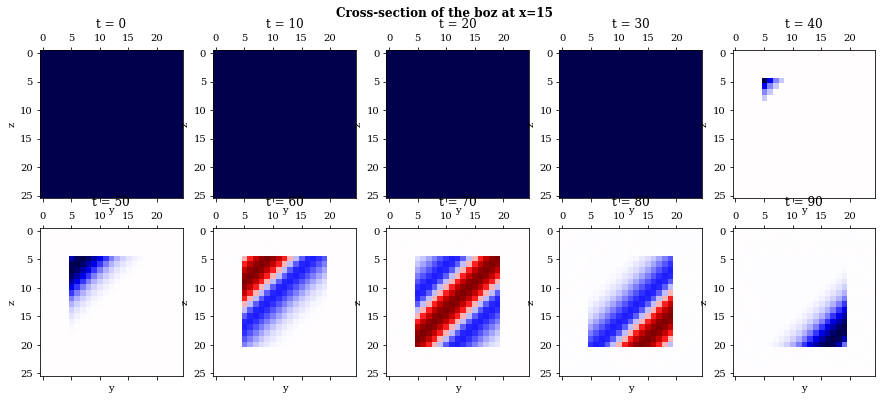

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[15, :, :, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('y')
        axes[i, j].set_ylabel('z')        

fig.suptitle('Cross-section of the boz at x=15', fontweight='bold')
plt.savefig('./crossSectionX.png')
plt.show()

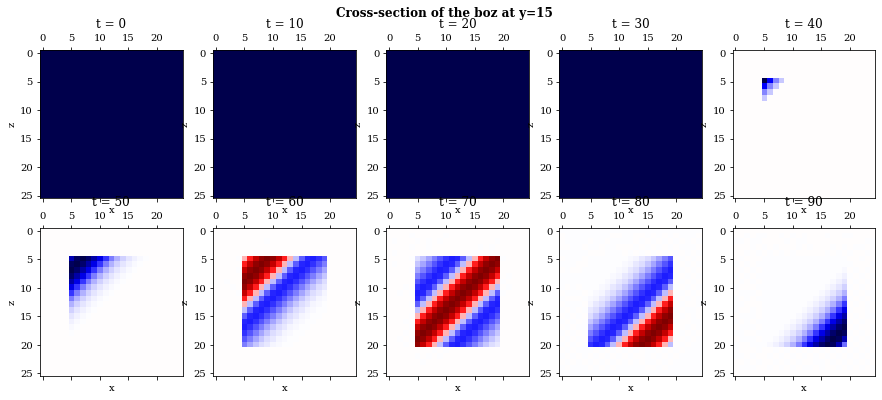

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[:, 15, :, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('x')
        axes[i, j].set_ylabel('z')        

fig.suptitle('Cross-section of the boz at y=15', fontweight='bold')
plt.savefig('./crossSectionY.png')
plt.show()

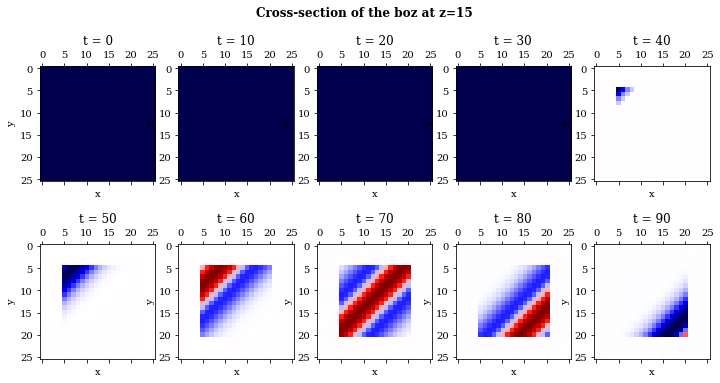

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[:, :, 15, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('x')
        axes[i, j].set_ylabel('y')        

fig.suptitle('Cross-section of the boz at z=15', fontweight='bold')
plt.savefig('./crossSectionZ.png')
plt.show()